# Fast LISA Response Tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from fastlisaresponse import pyResponseTDI, ResponseWrapper
from astropy import units as un

YRSID_SI = 31558149.763545603

## Gravitational wave signal

In [2]:
class GBWave:
    def __init__(self, use_gpu=False):

        if use_gpu:
            self.xp = xp
        else:
            self.xp = np

    def __call__(self, A, f, fdot, iota, phi0, psi, T=1.0, dt=10.0):

        t = self.xp.arange(0.0, T * YRSID_SI, dt)
        cos2psi = self.xp.cos(2.0 * psi)
        sin2psi = self.xp.sin(2.0 * psi)
        cosiota = self.xp.cos(iota)

        fddot = 11.0 / 3.0 * fdot ** 2 / f

        # phi0 is phi(t = 0, which is shifted due to t_buffer)
        phase = (
            2 * np.pi * (f * t + 1.0 / 2.0 * fdot * t ** 2 + 1.0 / 6.0 * fddot * t ** 3)
            - phi0
        )

        hSp = -self.xp.cos(phase) * A * (1.0 + cosiota * cosiota)
        hSc = -self.xp.sin(phase) * 2.0 * A * cosiota

        hp = hSp * cos2psi - hSc * sin2psi
        hc = hSp * sin2psi + hSc * cos2psi

        return hp + 1j * hc

## Build waveforms

### Setup classes

In [4]:
use_gpu = False

T = 2.0  # years

sampling_frequency = 0.1
dt = 1 / sampling_frequency

order = 25

# add your file path here
orbit_file = "../esa-orbits.h5"

tdi_kwargs = dict(
    orbit_kwargs=dict(orbit_file=orbit_file),
    order=order,
    tdi="1st generation",
    tdi_chan="XYZ",
)

gb = GBWave(use_gpu=use_gpu)

index_lambda = 6
index_beta = 7

gb_lisa = ResponseWrapper(
    gb,
    T,
    dt,
    index_lambda,
    index_beta,
    flip_hx=False,
    use_gpu=use_gpu,
    remove_sky_coords=True,
    is_ecliptic_latitude=True,
    **tdi_kwargs
)

A = 1.084702251e-22
f = 2.35962078e-3
fdot = 1.47197271e-17
iota = 1.11820901
phi0 = 4.91128699
psi = 2.3290324

beta = 0.9805742971871619
lam = 5.22979888



### Run generator

In [5]:
chans = gb_lisa(A, f, fdot, iota, phi0, psi, lam, beta)

### Plot results

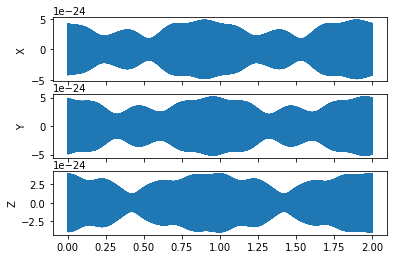

In [8]:
fig, ax = plt.subplots(3, 1, sharex=True)

for i, lab in enumerate(["X", "Y", "Z"]):
    ax[i].plot(np.arange(len(chans[0])) * dt / YRSID_SI, chans[i])
    ax[i].set_ylabel(lab)